LHAPDF 6.5.4 loading /home/ahmed/miniconda3/envs/env1/share/LHAPDF/NNPDF31_nnlo_as_0118/NNPDF31_nnlo_as_0118_0000.dat
NNPDF31_nnlo_as_0118 PDF set, member #0, version 1; LHAPDF ID = 303600


/tmp/ipykernel_120075/3658469024.py:54: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result, error = quad(integrand, tau, 1)
/tmp/ipykernel_120075/3658469024.py:107: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a specia

Result from Code 1: [27.821454049226226, 26.468326367906393, 26.093413602980394, 26.16890660453755, 25.38212381106646, 25.044190822747247, 24.718843849440322, 24.398976097977616, 24.09069409047166, 23.784255876414267, 23.47795261386008, 23.216577177818248, 23.55672809446128, 22.67190272325221, 22.902630354724632, 22.15437291259234, 21.760400342567447, 21.66158042321275, 21.275053433369102, 21.199620169813876, 21.13222669036966, 20.74224552295347, 20.525009484514843, 20.26278072922692, 20.104282568293364, 19.79200811105965, 19.700870768750537, 19.505209780701858, 19.313568233555706, 19.125664880928475, 18.94138582774244, 18.760627682341077, 18.58332481276814, 18.409285835305536, 18.237499174729038, 18.070803990075863, 17.90614279832687, 17.74441343389331, 17.585529626692566, 17.429623995071722, 17.275974053869984, 17.125147803693892, 16.976857524654054, 16.83096413632371, 16.687615550575675, 16.5465379473785, 16.407742564289205, 16.271169952516942, 16.136763372325387, 16.004466879548787

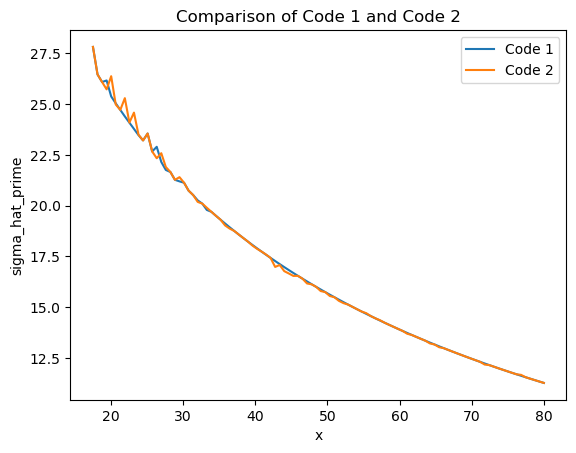

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import torch as tn
import lhapdf
pdf = lhapdf.mkPDF("NNPDF31_nnlo_as_0118", 0)

# Parameters
QQ = np.linspace(17.5,80,100)
C = tn.tensor([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0,0,0, -2e-5]
], dtype=tn.float32)

A = 1 / np.sqrt(2)
p1 = A * tn.tensor([1, 0, 0, 1], dtype=tn.float32)
p2 = A * tn.tensor([1, 0, 0, -1], dtype=tn.float32)
flavor = 2

n = 1

# Code 1 functions
def f_s_code1(x, tau_x, flavor, Q):
    return 1/x *pdf.xfxQ(flavor, x, Q) * 1/tau_x *pdf.xfxQ(-flavor, tau_x, Q) + \
           1/tau_x *pdf.xfxQ(flavor, tau_x, Q) *1/x * pdf.xfxQ(-flavor, x, Q)

def num_derivative_code1(func, x, h=1e-15, *args):
    return (func(x + h, *args) - func(x , *args)) / (h)

def f_prime_s_code1(x, tau_x, flavor, Q):
    f_f_tau_x_prime = num_derivative_code1(lambda t: 1/t *pdf.xfxQ(flavor, t, Q), tau_x)
    f_fbar_tau_x_prime = num_derivative_code1(lambda t:1/t *pdf.xfxQ(-flavor, t, Q), tau_x)
    
    return (1/x * pdf.xfxQ(flavor, x, Q) *f_fbar_tau_x_prime + \
           1/x *f_f_tau_x_prime *pdf.xfxQ(-flavor, x, Q))

def sigma_hat_prime_code1(x, tau_x, C, p1, p2, flavor, Q, n):
    term1 = (n + (0.5) * (1 + x / tau_x) *
             (tn.dot(p1, tn.mv(C, p2)) + tn.dot(p2, tn.mv(C, p1)) +
              tn.dot(p1, tn.mv(C, p1)) + tn.dot(p2, tn.mv(C, p2)))) * f_s_code1(x, tau_x, flavor, Q)
    
    term2 = (0.5) *(x * tn.dot(p1, tn.mv(C, p1)) + tau_x * tn.dot(p1, tn.mv(C, p2)) +
             tau_x * tn.dot(p1, tn.mv(C, p2)) + x * tn.dot(p2, tn.mv(C, p2)))* f_prime_s_code1(x, tau_x, flavor, Q)
    
    return term1 + term2

def integrate_sigma_hat_prime_code1(tau, C, p1, p2, flavor, Q, n):
    def integrand(x):
        tau_x = tau/x
        return sigma_hat_prime_code1(x, tau_x, C, p1, p2, flavor, Q, n) * tau_x
    
    result, error = quad(integrand, tau, 1)
    return result

# Code 2 functions
def f_s_code2(x, tau, flavor, Q):
    tau_x = tau / x
    pdf_flavor_x = pdf.xfxQ(flavor, x, Q)
    pdf_flavor_tau_x = pdf.xfxQ(flavor, tau_x, Q)
    pdf_anti_flavor_x = pdf.xfxQ(-flavor, x, Q)
    pdf_anti_flavor_tau_x = pdf.xfxQ(-flavor, tau_x, Q)

    term1 = (1 / x) * pdf_flavor_x * (1/tau_x) * pdf_anti_flavor_tau_x
    term2 = (1/tau_x) * pdf_flavor_tau_x * (1 / x) * pdf_anti_flavor_x
    
    return term1 + term2

def num_derivative_code2(func, x, h=1e-15, *args):
    return (func(x + h, *args) - func(x - h, *args)) / (2 * h)

def f_prime_s_code2(x, tau, flavor, Q):
    tau_x = tau/x
    f_f_tau_x_prime = num_derivative_code2(lambda t: 1/t * pdf.xfxQ(flavor, t, Q), tau_x)
    f_fbar_tau_x_prime = num_derivative_code2(lambda t: 1/t * pdf.xfxQ(-flavor, t, Q), tau_x)

    pdf_flavor_x = pdf.xfxQ(flavor, x, Q)
    pdf_anti_flavor_x = pdf.xfxQ(-flavor, x, Q)
    
    return 1/x * pdf_flavor_x * f_fbar_tau_x_prime + \
           1/x * f_f_tau_x_prime * pdf_anti_flavor_x

def sigma_hat_prime_code2(x, tau, C, p1, p2, flavor, Q):
    tau_x = tau / x

    f_s_val = f_s_code2(x, tau, flavor, Q)
    f_prime_s_val = f_prime_s_code2(x, tau, flavor, Q)

    contraction_p1p1 = tn.einsum('mn,m,n->', C, p1, p1)
    contraction_p1p2 = tn.einsum('mn,m,n->', C, p1, p2)
    contraction_p2p1 = tn.einsum('mn,m,n->', C, p2, p1)
    contraction_p2p2 = tn.einsum('mn,m,n->', C, p2, p2)
    
    term1 = f_s_val
    term2 = 0.5 * (1 + x / tau_x) * (contraction_p1p1 + contraction_p1p2 + contraction_p2p1 + contraction_p2p2) * f_s_val
    term3 = 0.5 * (x * contraction_p1p1 + tau_x * contraction_p1p2 + tau_x * contraction_p2p1 + x * contraction_p2p2) * f_prime_s_val
    
    return term1 + term2 + term3

def integrate_sigma_hat_prime_code2(tau, C, p1, p2, flavor, Q):
    def integrand(x):
        tau_x = tau / x
        total_sum = sigma_hat_prime_code2(x, tau, C, p1, p2, flavor, Q)
        return total_sum * tau_x

    result, _ = quad(integrand, tau, 1)
    return result


# Run the integration for both codes
result_code1 = [integrate_sigma_hat_prime_code1(Q**2/(13e3)**2, C, p1, p2, flavor, Q, n) for Q in QQ]
result_code2 = [integrate_sigma_hat_prime_code2(Q**2/(13e3)**2, C, p1, p2, flavor, Q) for Q in QQ]

# Print the results
print(f"Result from Code 1: {result_code1}")
print(f"Result from Code 2: {result_code2}")


plt.plot(QQ, result_code1, label='Code 1')
plt.plot(QQ, result_code2, label='Code 2')
plt.xlabel('x')
plt.ylabel('sigma_hat_prime')
plt.legend()
plt.title('Comparison of Code 1 and Code 2')
plt.show()


In [33]:
def term_11(Q2, e_f):
    return  e_f**2 / (2*Q2**2)

def term_21(Q2, e_f, g):
    return (((1 - (m_Z**2 / Q2)) / ((Q2 - m_Z**2)**2 + m_Z**2 * Gamma_Z**2)) *
            (1 - 4 * sin2th_w) / (4 * sin2th_w * (1- sin2th_w ))* e_f * g)

def term_31(Q2, e_f, g):
    return (1 / ((Q2 - m_Z**2)**2 + m_Z**2 * Gamma_Z**2) * 
            (1 + (1 - 4 * sin2th_w)**2) / (32 * sin2th_w**2 * (1-sin2th_w)**2)) * g**2

def summation_terms1(Q2, e_f, g):
    return 0.38 * 1e9*(term_11(Q2, e_f) + term_21(Q2, e_f, g) + term_31(Q2, e_f, g))

In [34]:
def term_1(Q2, e_f):
    return e_f**2 / (2*Q2**2)
    
def term_2(Q2, e_f, g):
    return (((1 - (m_Z**2 / Q2)) / ((Q2 - m_Z**2)**2 + m_Z**2 * Gamma_Z**2)) *
            (1 - 4 * sin2th_w) / (4 * sin2th_w * (1- sin2th_w ))* e_f * g)
            
def term_3(Q2, e_f, g):
    return (1 / ((Q2 - m_Z**2)**2 + m_Z**2 * Gamma_Z**2) * 
            (1 + (1 - 4 * sin2th_w)**2) / (32 * sin2th_w**2 * (1-sin2th_w)**2)) * g**2

def summation_terms2(Q2, e_f, g):
    return 0.38 * 1e9*(term_1(Q2, e_f) + term_2(Q2, e_f, g) + term_3(Q2, e_f, g))

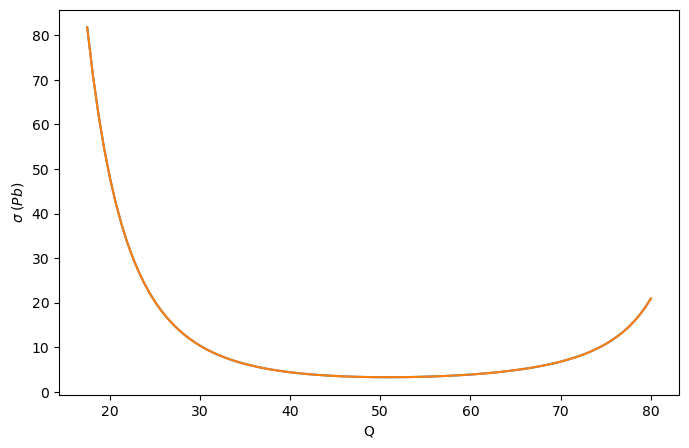

In [35]:
# Constants
s = (13e3)**2 # Center-of-mass energy squared in GeV^2
Nc = 3  # Number of colors in QCD
m_Z = 91.1876  # Mass of the Z boson in GeV/c^2
Gamma_Z = 2.4952  # Decay width of the Z boson in GeV
alpha = 1 / 137  # Fine-structure constant
sin2th_w = 0.23121  # sin^2(theta_W)
e = 0.3028 # Elementry charge in natural units

kk =[summation_terms1(Q**2, 0.2013, 0.4551) for Q in QQ] 
kp =[summation_terms2(Q**2, 0.2013, 0.4551) for Q in QQ] 
plt.figure(figsize=(8, 5))

# Create the step plot
plt.plot(QQ, kk)
plt.plot(QQ, kp)

plt.xlabel('Q')
# plt.yscale('log')
plt.ylabel('$\\sigma \\;(Pb)$')
# plt.title(f'Integrated d_sigma over Q bins for $C^{{33}}_{{uL}}=${c_33L} and $C^{{33}}_{{uR}}=${c_33R}')
plt.show()

In [21]:
def f_s(x, tau, flavor, Q2):
    tau_x = tau / x
    pdf_flavor_x = pdf.xfxQ(flavor, x, Q2)
    pdf_flavor_tau_x = pdf.xfxQ(flavor, tau_x, Q2)
    pdf_anti_flavor_x = pdf.xfxQ(-flavor, x, Q2)
    pdf_anti_flavor_tau_x = pdf.xfxQ(-flavor, tau_x, Q2)

    term1 = (1 / x) * pdf_flavor_x * (1/tau_x) * pdf_anti_flavor_tau_x
    term2 = (1/tau_x) * pdf_flavor_tau_x * (1 / x) * pdf_anti_flavor_x
    
    return term1 + term2

In [22]:
s= (13e3)**2
def f_s2(x, tau, flavor, Q2):
    tau_x = tau / x
    pdf_flavor_x = pdf.xfxQ(flavor, x, Q2)
    pdf_flavor_tau_x = pdf.xfxQ(flavor, tau_x, Q2)
    pdf_anti_flavor_x = pdf.xfxQ(-flavor, x, Q2)
    pdf_anti_flavor_tau_x = pdf.xfxQ(-flavor, tau_x, Q2)

    term1 = (1 / x) * pdf_flavor_x * (1/tau_x) * pdf_anti_flavor_tau_x
    term2 = (1/tau_x) * pdf_flavor_tau_x * (1 / x) * pdf_anti_flavor_x
    
    return term1 + term2

In [27]:
gg =[f_s(0.5, Q**2/s,2, Q) for Q in QQ]
ff =[f_s2(0.5, Q**2/s,2, Q**2) for Q in QQ]


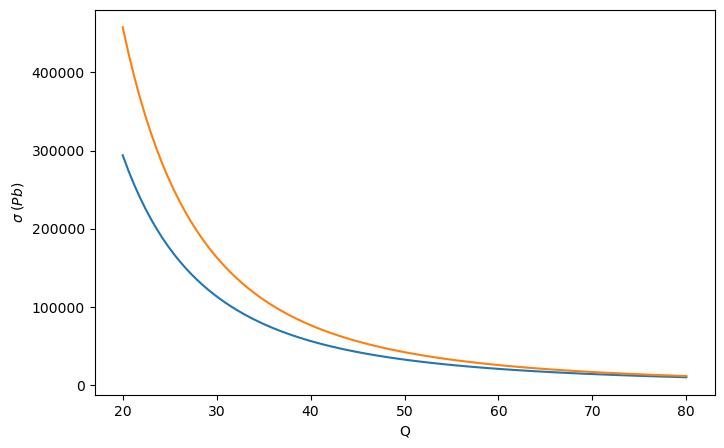

In [28]:
plt.figure(figsize=(8, 5))

# Create the step plot
plt.plot(QQ, gg)
plt.plot(QQ, ff)

plt.xlabel('Q')
# plt.yscale('log')
plt.ylabel('$\\sigma \\;(Pb)$')
# plt.title(f'Integrated d_sigma over Q bins for $C^{{33}}_{{uL}}=${c_33L} and $C^{{33}}_{{uR}}=${c_33R}')
plt.show()

In [29]:
def f_s(x, tau, flavor, Q):
    tau_x = tau / x
    pdf_flavor_x = pdf.xfxQ(flavor, x, Q)
    pdf_flavor_tau_x = pdf.xfxQ(flavor, tau_x, Q)
    pdf_anti_flavor_x = pdf.xfxQ(-flavor, x, Q)
    pdf_anti_flavor_tau_x = pdf.xfxQ(-flavor, tau_x, Q)

    term1 = (1 / x) * pdf_flavor_x * (1/tau_x) * pdf_anti_flavor_tau_x
    term2 = (1/tau_x) * pdf_flavor_tau_x * (1 / x) * pdf_anti_flavor_x
    
    return term1 + term2


def num_derivative(func, x, h=1e-8, *args):
    return (func(x + h, *args) - func(x - h, *args)) / (2 * h)


def f_prime_s(x, tau, flavor, Q):
    tau_x = tau/x
    f_f_tau_x_prime = num_derivative(lambda t: 1/t * pdf.xfxQ(flavor, t, Q), tau_x)
    f_fbar_tau_x_prime = num_derivative(lambda t: 1/t * pdf.xfxQ(-flavor, t, Q), tau_x)

    pdf_flavor_x = pdf.xfxQ(flavor, x, Q)
    pdf_anti_flavor_x = pdf.xfxQ(-flavor, x, Q)
    
    return (1/x * pdf_flavor_x * f_fbar_tau_x_prime + \
           1/x * f_f_tau_x_prime * pdf_anti_flavor_x)


def sigma_hat_prime(x, tau, C, p1, p2, flavor, Q):
    tau_x = tau/x

    f_s_val = f_s(x, tau, flavor, Q)
    f_prime_s_val = f_prime_s(x, tau, flavor, Q)

    # Efficiently handle the contraction with non-zero elements of C
    contraction_p1p1 = tn.einsum('mn,m,n->', C, p1, p1)
    contraction_p1p2 = tn.einsum('mn,m,n->', C, p1, p2)
    contraction_p2p1 = tn.einsum('mn,m,n->', C, p2, p1)
    contraction_p2p2 = tn.einsum('mn,m,n->', C, p2, p2)
    
    term1 = f_s_val
    
    term2 = 0.5 * (1 + x / tau_x) * (contraction_p1p1 + contraction_p1p2 +  contraction_p2p1 + contraction_p2p2) * f_s_val
    
    term3 = 0.5 * (x * contraction_p1p1 +  tau_x * contraction_p1p2 + tau_x * contraction_p2p1 + x * contraction_p2p2) * f_prime_s_val
    
    return term1, term2 + term3

def integrate_sigma_hat_prime_sm(tau, flavor, Q):
    def integrand1(x):
        tau_x = tau/x
        return f_s(x, tau, flavor, Q) * tau_x
    
    result1, _ = quad(integrand1, tau, 1)
    return result1

def integrate_sigma_hat_prime_sme(tau, C, p1, p2, flavor, Q):
    def integrand2(x):
        tau_x = tau / x
        _, term2_plus_term3 = sigma_hat_prime(x, tau, C, p1, p2, flavor, Q)
        return term2_plus_term3 * tau_x

    result2, _ = quad(integrand2, tau, 1)

    return result2

In [30]:
A = 1 / np.sqrt(2)
p1 = A * tn.tensor([1, 0, 0, 1], dtype=tn.float32)
p2 = A * tn.tensor([1, 0, 0, -1], dtype=tn.float32)
QQ2= np.linspace(20**2,80**2,100)

jk = [(integrate_sigma_hat_prime_sme(Q2/s,CLzz, p1, p2,2, Q)+ integrate_sigma_hat_prime_sm(Q2/s, 2, Q2) )for Q in QQ2]

plt.figure(figsize=(8, 5))

# Create the step plot
plt.plot(QQ, jk)

plt.xlabel('Q')
# plt.yscale('log')
plt.ylabel('$\\sigma \\;(Pb)$')
# plt.title(f'Integrated d_sigma over Q bins for $C^{{33}}_{{uL}}=${c_33L} and $C^{{33}}_{{uR}}=${c_33R}')
plt.show()

NameError: name 'CLzz' is not defined

In [36]:
80*27*4*3.14/9*(137)**-2

0.1606052533432788